In [ ]:
# pip install traci

In [ ]:
# pip install pandas

### Importing libraries

In [1]:
import os
import sys
import traci
import pandas as pd
from sumolib import checkBinary

In [2]:
os.environ["SUMO_HOME"] = "/usr/share/sumo"
print("SUMO_HOME set to:", os.environ["SUMO_HOME"])

SUMO_HOME set to: /usr/share/sumo


In [3]:
#Path to sumo config file
sumo_config_file = "/home/ruby/Nazmus Shakib/AARC Lab/Enhance Mix Traffic Flow Recreation/main_config.sumocfg"

# Output CSV file
output_csv = "sumo_simulated_vehicle_data.csv"

# Initialize the SUMO simulation
sumo_cmd = ["sumo", "-c", sumo_config_file]
# traci.start(sumo_cmd)

### Creating dataframe to store data

In [4]:
col_names = ["Timestamp", "Lane", "Vehicle_Id", "Vehicle_Type", "Speed", "Acc", "x_Position"]
all_lane_data = pd.DataFrame(columns=col_names)

# Creating empty dataframe to store lane-wise data
left_lane = []
mid_lane = []
right_lane = []
ramp_lane = []

# Lane IDs extracted from road.net.xml file
left_lane_ids = ["1_2", "3_3", "4_2", "0_1_2", "1_0_3"]
mid_lane_ids = ["1_1", "3_2", "4_1", "0_1_1", "1_0_2"]
right_lane_ids = ["1_0", "3_1", "4_0", "0_1_0", "1_0_1"]
merged_lane_id = ["3_0"]

### Running Simulation

#### Control function

In [5]:
# Dictionary to track platoon memberships
platoon_data = {}  # Key: leader_id, Value: list of vehicles in the platoon

# Dictionary to track each vehicle's current mode
vehicle_modes = {}  # Key: vehicle_id, Value: mode

# IDM Parameters (for HDVs)
IDM_DESIRED_SPEED = 30.56  # m/s
IDM_TIME_HEADWAY = 1.5  # s
IDM_MAX_ACCEL = 1.4  # m/s²
IDM_DECEL = 2.0 # m/s²
IDM_MIN_GAP = 2.0  # m

# CACC Parameters (for CAVs)
CACC_FOLLOWING_DISTANCE = 20  # m
CACC_CATCH_UP_DISTANCE = 120  # m
CACC_KP = 0.5  # Proportional gain for speed error
CACC_KD = 0.3  # Derivative gain for acceleration difference
PLATOON_SIZE_THRESHOLD = 9  # Max platoon size

# CACC Parameters (for CAVs)
CACC_PARAMS = {
    "leading_mode": {"time_headway": 1.1, "speed_factor": 1.0},
    "following_mode": {"time_headway": 0.6, "speed_factor": 1.1},
    "lead-catching_mode": {"time_headway": 0.7, "speed_factor": 1.2},
    "catch-up_following_mode": {"time_headway": 0.6, "speed_factor": 1.3},
    "catching_mode": {"time_headway": 0.7, "speed_factor": 1.2},
}

def get_platoon_size(leader_id):
    """Returns the size of the platoon."""
    return len(platoon_data.get(leader_id, [leader_id]))  # Include leader

def join_platoon(leader_id, vehicle_id):
    """Joins an existing platoon if not full, else starts a new platoon."""
    if leader_id in platoon_data:
        if len(platoon_data[leader_id]) < PLATOON_SIZE_THRESHOLD:
            platoon_data[leader_id].append(vehicle_id)
            return True  # Joined successfully
        return False  # Platoon full
    platoon_data[leader_id] = [leader_id, vehicle_id]  # Create new platoon
    return True

def IDM_control(vehicle_id, leader_id, gap, current_speed):
    """Implements IDM acceleration control for non-CAV vehicles."""
    if leader_id and gap is not None:
        leader_speed = traci.vehicle.getSpeed(leader_id)
        delta_speed = current_speed - leader_speed  # Speed difference

        # Compute desired gap
        s_star = IDM_MIN_GAP + max(0, current_speed * IDM_TIME_HEADWAY + (current_speed * delta_speed) / (2 * (IDM_MAX_ACCEL * IDM_DECEL) ** 0.5))

        # Compute acceleration using IDM formula
        acceleration = IDM_MAX_ACCEL * (1 - (current_speed / IDM_DESIRED_SPEED) ** 4 - (s_star / gap) ** 2)

        # Apply acceleration limits
        acceleration = max(-IDM_DECEL, min(acceleration, IDM_MAX_ACCEL))

        return acceleration
    else:
        return IDM_MAX_ACCEL  # Free-flow acceleration

def CACC_control(vehicle_id, leader_id, gap, current_speed, mode):
    if leader_id and gap is not None:
        leader_speed = traci.vehicle.getSpeed(leader_id)
        leader_accel = traci.vehicle.getAcceleration(leader_id)

        speed_error = leader_speed - current_speed
        acceleration_command = CACC_KP * speed_error + CACC_KD * leader_accel

        if mode in CACC_PARAMS:
            acceleration_command *= CACC_PARAMS[mode]["speed_factor"]  #Applying Speed Factor

        return acceleration_command
    return 0


def control_func(vehicle_id):
    """Applies IDM or CACC acceleration control to vehicles based on their type."""
    v_type = traci.vehicle.getTypeID(vehicle_id)
    is_cav = "CAV_ori" in v_type
    current_speed = traci.vehicle.getSpeed(vehicle_id)

    # Get leader information
    leader_info = traci.vehicle.getLeader(vehicle_id)
    leader_id, gap = leader_info if leader_info else (None, None)

    # **IDM for Non-CAVs**
    if not is_cav:
        acceleration = IDM_control(vehicle_id, leader_id, gap, current_speed)

        # Apply acceleration change properly
        traci.vehicle.setAcceleration(vehicle_id, acceleration, 1)
        return

    # **CACC for CAVs**
    current_mode = vehicle_modes.get(vehicle_id, "default")

    if leader_id and gap is not None:
        leader_type = traci.vehicle.getTypeID(leader_id)

        if "CAV_ori" in leader_type and gap < CACC_CATCH_UP_DISTANCE:
            platoon_size = get_platoon_size(leader_id)

            if gap < CACC_FOLLOWING_DISTANCE:
                current_mode = "following_mode"
            elif gap < CACC_CATCH_UP_DISTANCE:
                current_mode = "catch-up_following_mode" if platoon_size < PLATOON_SIZE_THRESHOLD else "catching_mode"
            else:
                current_mode = "lead-catching_mode"

            success = join_platoon(leader_id, vehicle_id) if platoon_size < PLATOON_SIZE_THRESHOLD else False
            if not success:
                current_mode = "leading_mode"
                platoon_data[vehicle_id] = [vehicle_id]

            acceleration = CACC_control(vehicle_id, leader_id, gap, current_speed, current_mode)

        else:
            # No front CAV detected within 120m
            current_mode = "leading_mode"
            platoon_data[vehicle_id] = [vehicle_id]
            acceleration = 0  # Maintain speed in leading mode

    else:
        # No leader detected
        current_mode = "leading_mode"
        acceleration = 0  # Maintain speed

    # Store vehicle mode
    vehicle_modes[vehicle_id] = current_mode

    # Apply acceleration instead of speed change
    traci.vehicle.setAcceleration(vehicle_id, acceleration, 1)

    # print(f"Vehicle {vehicle_id} | Mode: {current_mode} | Platoon Size: {get_platoon_size(vehicle_id)} | Gap: {gap} | Accel: {acceleration:.2f} m/s²")


### Demo code

In [ ]:
# import traci
# import pandas as pd
# import random

# # Simulation Parameters
# MAX_TIME = 3600  # Total simulation duration in seconds
# INTERVAL = 600  # Update interval (every 10 minutes)
# LANES = 3  # Number of lanes
# BASELINE_FLOW_PER_LANE = 2400  # Initial flow per lane (vehicles per hour)
# INCREMENT_PER_LANE = 300  # Additional vehicles per hour per lane at each step
# INITIAL_CAV_RATIO = 0.2  # Start with 20% CAVs
# FINAL_CAV_RATIO = 1.0  # End with 100% CAVs
# MPR_CHECKPOINTS = [0.2, 0.4, 0.6, 0.8, 1.0]  # Save data at these MPR intervals

# # Vehicle Types (Must be defined in .rou.xml)
# HDV_TYPE = "HDV_ori"
# CAV_TYPE = "CAV_ori"

# # Lane ID Classification
# left_lane_ids = ["1_2", "3_3", "4_2", "0_1_2", "1_0_3"]
# mid_lane_ids = ["1_1", "3_2", "4_1", "0_1_1", "1_0_2"]
# right_lane_ids = ["1_0", "3_1", "4_0", "0_1_0", "1_0_1"]
# merged_lane_id = ["3_0"]

# # Define valid routes based on lane IDs
# ROUTES = ["r_1", "r_2"]

# # Start SUMO TraCI
# traci.start(sumo_cmd)

# # Data storage per MPR level for each lane
# lane_data_per_mpr = {mpr: {"left": [], "mid": [], "right": [], "ramp": []} for mpr in MPR_CHECKPOINTS}
# col_names = ["time", "lane", "vehicle_id", "vehicle_type", "speed", "acceleration", "x_position"]

# # Track vehicle count
# vehicle_counter = 0

# # Simulation loop
# while traci.simulation.getTime() < MAX_TIME and traci.simulation.getMinExpectedNumber() > 0:
#     traci.simulationStep()  # Advance simulation
#     time_step = traci.simulation.getTime()

#     # Calculate new traffic demand
#     flow_per_lane = BASELINE_FLOW_PER_LANE + ((time_step // INTERVAL) * INCREMENT_PER_LANE)
#     total_flow = flow_per_lane * LANES  # Total vehicles per hour for all lanes

#     # Adjust CAV ratio dynamically
#     cav_ratio = min(FINAL_CAV_RATIO, INITIAL_CAV_RATIO + (time_step / MAX_TIME) * (FINAL_CAV_RATIO - INITIAL_CAV_RATIO))

#     # Compute new vehicle distribution
#     new_cav_flow = int(total_flow * cav_ratio)  # CAVs
#     new_hdv_flow = total_flow - new_cav_flow  # HDVs

#     # Inject new vehicles into the simulation
#     if time_step % INTERVAL == 0:
#         vehicles_per_interval = total_flow // 3600  # Convert veh/h to veh/sec
#         for _ in range(int(vehicles_per_interval * INTERVAL)):  # Add vehicles for the interval
#             vehicle_id = f"veh_{vehicle_counter}"
#             vehicle_type = CAV_TYPE if random.random() < cav_ratio else HDV_TYPE
#             route_id = random.choice(ROUTES)  # Assign a valid route

#             try:
#                 traci.vehicle.add(vehID=vehicle_id, routeID=route_id, typeID=vehicle_type)
#                 vehicle_counter += 1
#             except traci.TraCIException as e:
#                 pass
#                 # print(f"Error adding vehicle {vehicle_id}: {e}")  # Debugging message

#         # print(f"Time: {time_step}s - Total Flow: {total_flow} veh/h | CAV: {new_cav_flow} veh/h | HDV: {new_hdv_flow} veh/h")

#     # Get all vehicle IDs
#     vehicles_ids = traci.vehicle.getIDList()

#     for v_id in vehicles_ids:
#         # Retrieve vehicle information
#         lane_id = traci.vehicle.getLaneID(v_id)
#         v_type = traci.vehicle.getTypeID(v_id)
#         v_speed = traci.vehicle.getSpeed(v_id)
#         v_acc = traci.vehicle.getAcceleration(v_id)
#         v_xpos = traci.vehicle.getPosition(v_id)

#         # Apply control function and platoon mechanism
#         control_func(v_id)

#         # Store lane-wise data for the nearest MPR checkpoint
#         for target_mpr in MPR_CHECKPOINTS:
#             if abs(cav_ratio - target_mpr) < 0.05:  # Save data when close to target MPR
#                 if lane_id in left_lane_ids:
#                     lane_data_per_mpr[target_mpr]["left"].append([time_step, "left", v_id, v_type, v_speed, v_acc, v_xpos[0]])

#                 elif lane_id in mid_lane_ids:
#                     lane_data_per_mpr[target_mpr]["mid"].append([time_step, "mid", v_id, v_type, v_speed, v_acc, v_xpos[0]])

#                 elif lane_id in right_lane_ids:
#                     lane_data_per_mpr[target_mpr]["right"].append([time_step, "right", v_id, v_type, v_speed, v_acc, v_xpos[0]])

#                 elif lane_id in merged_lane_id:
#                     lane_data_per_mpr[target_mpr]["ramp"].append([time_step, "ramp", v_id, v_type, v_speed, v_acc, v_xpos[0]])

# # Close SUMO simulation
# traci.close()

# # Save data for each 20% MPR in separate CSV files for each lane
# for mpr, lane_data in lane_data_per_mpr.items():
#     for lane, data in lane_data.items():
#         if data:
#             df = pd.DataFrame(data, columns=col_names)
#             filename = f"traffic_data_MPR_{int(mpr*100)}_{lane}.csv"
#             df.to_csv(filename, index=False)
#             print(f"Successfully saved: {filename}")


In [9]:
import traci
import pandas as pd
import random

# Simulation Parameters
MAX_TIME = 3600  # Total simulation duration in seconds
IGNORE_TIME = 500  # Ignore first 500s
INTERVAL = 600  # Update interval (every 10 minutes)
LANES = 3  # Number of lanes
BASELINE_FLOW_PER_LANE = 2400  # Initial flow per lane (vehicles per hour)
INCREMENT_PER_LANE = 300  # Additional vehicles per hour per lane at each step
MPR_RATE = 0.2  # Fix CAV ratio at 20% (Only generating data for 20% MPR)

# Vehicle Types (Must be defined in .rou.xml)
HDV_TYPE = "HDV_ori"
CAV_TYPE = "CAV_ori"

# Lane ID Classification
left_lane_ids = ["1_2", "3_3", "4_2", "0_1_2", "1_0_3"]
mid_lane_ids = ["1_1", "3_2", "4_1", "0_1_1", "1_0_2"]
right_lane_ids = ["1_0", "3_1", "4_0", "0_1_0", "1_0_1"]
merged_lane_id = ["3_0"]

# Define valid routes based on lane IDs
ROUTES = ["r_1", "r_2"]

# Start SUMO TraCI
traci.start(sumo_cmd)

# Data storage for each lane
lane_data = {"left": [], "mid": [], "right": [], "ramp": []}
col_names = ["time", "lane", "vehicle_id", "vehicle_type", "speed", "acceleration", "x_position"]

# Track vehicle count
vehicle_counter = 0

# Simulation loop
while traci.simulation.getTime() < MAX_TIME and traci.simulation.getMinExpectedNumber() > 0:
    traci.simulationStep()  # Advance simulation
    time_step = traci.simulation.getTime()

    if time_step <= IGNORE_TIME:
        continue  # Ignore data before 500s

    # Calculate new traffic demand
    flow_per_lane = BASELINE_FLOW_PER_LANE + ((time_step // INTERVAL) * INCREMENT_PER_LANE)
    total_flow = flow_per_lane * LANES  # Total vehicles per hour for all lanes

    # Compute new vehicle distribution
    new_cav_flow = int(total_flow * MPR_RATE)  # 20% CAVs
    new_hdv_flow = total_flow - new_cav_flow  # Remaining HDVs

    # Inject new vehicles into the simulation
    if time_step % INTERVAL == 0:
        vehicles_per_interval = total_flow // 3600  # Convert veh/h to veh/sec
        for _ in range(int(vehicles_per_interval * INTERVAL)):  # Add vehicles for the interval
            vehicle_id = f"veh_{vehicle_counter}"
            vehicle_type = CAV_TYPE if random.random() < MPR_RATE else HDV_TYPE
            route_id = random.choice(ROUTES)  # Assign a valid route

            try:
                traci.vehicle.add(vehID=vehicle_id, routeID=route_id, typeID=vehicle_type)
                vehicle_counter += 1
            except traci.TraCIException:
                pass  # Ignore errors

    # Get all vehicle IDs
    vehicles_ids = traci.vehicle.getIDList()

    for v_id in vehicles_ids:
        # Retrieve vehicle information
        lane_id = traci.vehicle.getLaneID(v_id)
        v_type = traci.vehicle.getTypeID(v_id)
        v_speed = traci.vehicle.getSpeed(v_id)
        v_acc = traci.vehicle.getAcceleration(v_id)
        v_xpos = traci.vehicle.getPosition(v_id)

        # Apply control function and platoon mechanism
        control_func(v_id)

        # Store lane-wise data
        if lane_id in left_lane_ids:
            lane_data["left"].append([time_step, "left", v_id, v_type, v_speed, v_acc, v_xpos[0]])

        elif lane_id in mid_lane_ids:
            lane_data["mid"].append([time_step, "mid", v_id, v_type, v_speed, v_acc, v_xpos[0]])

        elif lane_id in right_lane_ids:
            lane_data["right"].append([time_step, "right", v_id, v_type, v_speed, v_acc, v_xpos[0]])

        elif lane_id in merged_lane_id:
            lane_data["ramp"].append([time_step, "ramp", v_id, v_type, v_speed, v_acc, v_xpos[0]])

# Close SUMO simulation
traci.close()

# Save data for 20% MPR in separate CSV files for each lane
for lane, data in lane_data.items():
    if data:
        df = pd.DataFrame(data, columns=col_names)
        filename = f"traffic_data_MPR_20_{lane}.csv"
        df.to_csv(filename, index=False)
        print(f"Successfully saved: {filename}")


 Retrying in 1 seconds
***Starting server on port 33247 ***
Loading net-file from '/home/ruby/Nazmus Shakib/AARC Lab/Enhance Mix Traffic Flow Recreation/road.net.xml' ... done (0ms).
Loading route-files incrementally from '/home/ruby/Nazmus Shakib/AARC Lab/Enhance Mix Traffic Flow Recreation/route.rou.xml'
Loading done.
Simulation version 1.22.0 started with time: 0.00.


Simulation ended at time: 3600.00.
Reason: TraCI requested termination.
Performance:
 Duration: 722.92s
 TraCI-Duration: 702.64s
 Real time factor: 4.9798
 UPS: 7106.761467
Vehicles:
 Inserted: 860 (Loaded: 15601)
 Running: 114
 Waiting: 12941
 Teleports: 11 (Jam: 11)
Successfully saved: traffic_data_MPR_20_left.csv
Successfully saved: traffic_data_MPR_20_mid.csv
Successfully saved: traffic_data_MPR_20_right.csv
Successfully saved: traffic_data_MPR_20_ramp.csv


In [ ]:
# MAX_TIME = 100
# traci.start(sumo_cmd)

# while traci.simulation.getTime()<MAX_TIME and traci.simulation.getMinExpectedNumber()>0:
#     traci.simulationStep() #advance simulation by one step
#     time_step = traci.simulation.getTime()

#     #get all vehicles ids
#     vehicles_ids = traci.vehicle.getIDList()

#     for v_id in vehicles_ids:
#         #get all info for each vehicles
#         lane_id = traci.vehicle.getLaneID(v_id)
#         v_type = traci.vehicle.getTypeID(v_id)
#         v_speed = traci.vehicle.getSpeed(v_id)
#         v_acc = traci.vehicle.getAcceleration(v_id)
#         v_xpos = traci.vehicle.getPosition(v_id)

#         #appying control function and platoon control mechanism in each vehicle
#         control_func(v_id)

#         #lanewaise control and data store
#         if lane_id in left_lane_ids:
#             left_lane.append([time_step, "left", v_id, v_type, v_speed, v_acc, v_xpos[0]])

#         elif lane_id in mid_lane_ids:
#             mid_lane.append([time_step, "mid", v_id, v_type, v_speed, v_acc, v_xpos[0]])

#         elif lane_id in right_lane_ids:
#             right_lane.append([time_step, "right", v_id, v_type, v_speed, v_acc, v_xpos[0]])

#         elif lane_id in merged_lane_id:
#             ramp_lane.append([time_step, "ramp", v_id, v_type, v_speed, v_acc, v_xpos[0]])

# traci.close()

# left_lane_df = pd.DataFrame(left_lane, columns=col_names)
# mid_lane_df = pd.DataFrame(mid_lane, columns=col_names)
# right_lane_df = pd.DataFrame(right_lane, columns=col_names)
# ramp_lane_df = pd.DataFrame(ramp_lane, columns=col_names)


# all_lane_data = pd.concat([left_lane_df, mid_lane_df, right_lane_df, ramp_lane_df], axis=1)
# all_lane_data.to_csv("all_lane_data_new.csv", index=False)
# print("Successfully saved!")

### Importing dataset

/home/ruby/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


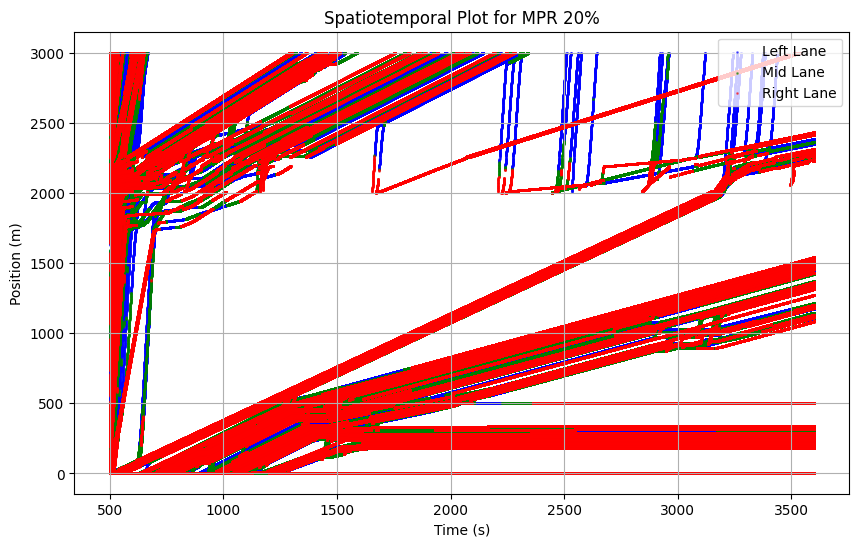

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 📌 Define Parameters
MPR_RATE = 20  # MPR 20% dataset
TIME_RANGE = (500, 3600)  # Ignore first 500s
POSITION_RANGE = (0, 3000)  # Road length in meters
LANES = ["left", "mid", "right"]  # Only plot these lanes
COLORS = ["blue", "green", "red"]  # Different colors for each lane

# 📌 Load All Lane Data
lane_data = {}
for lane in LANES:
    file_path = f"traffic_data_MPR_{MPR_RATE}_{lane}.csv"
    try:
        lane_data[lane] = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File {file_path} not found, skipping...")
        continue

# 📌 Create Plot
plt.figure(figsize=(10, 6))

for lane, color in zip(lane_data.keys(), COLORS):
    df = lane_data[lane]

    # ✅ Filter Data within Position and Time Range
    df = df[(df["time"] >= TIME_RANGE[0]) & (df["time"] <= TIME_RANGE[1])]
    df = df[(df["x_position"] >= POSITION_RANGE[0]) & (df["x_position"] <= POSITION_RANGE[1])]

    # ✅ Scatter Plot of Position vs. Time
    plt.scatter(df["time"], df["x_position"], color=color, label=f"{lane.capitalize()} Lane", alpha=0.5, s=1)

# ✅ Final Plot Settings
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title(f"Spatiotemporal Plot for MPR {MPR_RATE}%")
plt.legend()
plt.grid(True)

plt.show()


### Importing dataset

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("/home/ruby/Nazmus Shakib/AARC Lab/Enhance Mix Traffic Flow Recreation/all_lane_data_with_control_func.csv")

# Display the first few rows
print(df.head())

# Check the column names
print(df.columns)


In [ ]:
# Extract data for each lane
left_lane = df[df['Lane'] == 'left']
mid_lane = df[df['Lane.1'] == 'mid']
right_lane = df[df['Lane.2'] == 'right'] 

# Compute Density (vehicles/km) for each lane
left_lane['Density'] = left_lane.groupby('Timestamp')['Vehicle_Id'].transform('count') / 3.25
mid_lane['Density'] = mid_lane.groupby('Timestamp.1')['Vehicle_Id.1'].transform('count') / 3.25
right_lane['Density'] = right_lane.groupby('Timestamp.2')['Vehicle_Id.2'].transform('count') / 3.25

# Compute Flow (vehicles/hour) for each lane
left_lane['Flow'] = left_lane['Density'] * left_lane['Speed']
mid_lane['Flow'] = mid_lane['Density'] * mid_lane['Speed.1']
right_lane['Flow'] = right_lane['Density'] * right_lane['Speed.2']

In [ ]:
print(left_lane['Flow'])

In [ ]:
pip install --upgrade pip setuptools wheel

In [ ]:
pip install matplotlib

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))

# Plot Left Lane (Blue)
plt.scatter(left_lane['Density'], left_lane['Flow'], color='blue', label="Left Lane")

# Plot Middle Lane (Green)
plt.scatter(mid_lane['Density'], mid_lane['Flow'], color='green', label="Middle Lane")

# Plot Right Lane (Red)
plt.scatter(right_lane['Density'], right_lane['Flow'], color='red', label="Right Lane")

# Labels and Legend
plt.xlabel("Density (vehicles/km)")
plt.ylabel("Flow (vehicles/hour)")
plt.title("Flow-Density Relationship for Different Lanes")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
